In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import pickle


from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from src.models import gan, ganFirstGenerator#, aae  # , vae
 
from src.common.helperfunctions import *
from src.common.accuracy_XGboost import *


import xgboost as xgb
import time
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    recall_score,
    precision_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_name = 'data/raw/creditcard.csv'
df = pd.read_csv(file_name)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
label_col = []
feature_cols = []
label_col = [i for i in df.columns if 'Class' in i]
feature_cols = [i for i in df.columns if i not in label_col]

In [4]:
# X = df.loc[:,feature_cols]
# y = df.loc[:,label_col]

In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [6]:
# train = pd.concat([train_X, train_y], axis=1)

In [7]:
sc = StandardScaler()
train.loc[:,'Amount'] = sc.fit_transform(train.Amount.values.reshape(-1, 1))
train.loc[:,'Time'] = sc.fit_transform(train.Time.values.reshape(-1, 1))
test.loc[:,'Amount'] = sc.transform(test.Amount.values.reshape(-1, 1))
test.loc[:,'Time'] = sc.transform(test.Time.values.reshape(-1, 1))
# train.drop('Time',axis=1, inplace=True)
# test.drop('Time', axis=1, inplace=True)

/home/chinne/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/chinne/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/chinne/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [8]:
# mxs = MinMaxScaler()
# train.iloc[:,:] = mxs.fit_transform(train.iloc[:,:].values)
# test.iloc[:,:] = mxs.transform(test.iloc[:,:].values)
# # train.drop('Time',axis=1, inplace=True)
# # test.drop('Time', axis=1, inplace=True)

In [9]:
train_Class = train[train.Class == 1]

In [10]:
label_col = []
feature_cols = []
label_col = [i for i in train.columns if 'Class' in i]
feature_cols = [i for i in train.columns if i not in label_col]

# Train GAN

In [11]:
train_Class.drop('Class', axis = 1,inplace=True)
# train_Class.drop('Time', axis = 1,inplace=True)

/home/chinne/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [12]:
train_Class.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [13]:
dataloader = prepareDataset(train_Class, batch_size = 128, device = 'cpu', withLabel = False)

In [14]:
dataloader.dataset.features.size(1)

30

Generator(
  (main): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Linear(in_features=256, out_features=30, bias=True)
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=30, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Starting Training Loop...
394 394
epoch: 0, Accuracy: 0.8324873096446701
[0/701]	Loss_D: 0.3434	Loss_G: 0.6331	


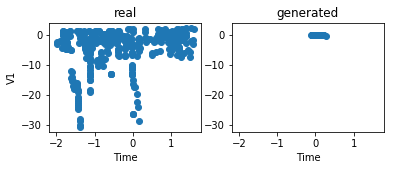

394 394
epoch: 10, Accuracy: 0.9695431472081218
[10/701]	Loss_D: 0.2175	Loss_G: 2.5606	


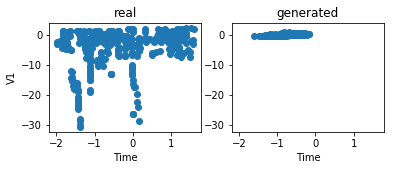

394 394
epoch: 20, Accuracy: 0.9949238578680203
[20/701]	Loss_D: 0.1612	Loss_G: 2.7557	


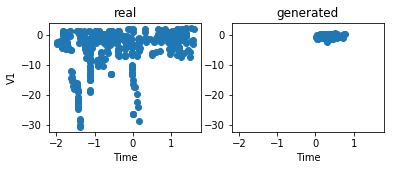

394 394
epoch: 30, Accuracy: 0.9847715736040609
[30/701]	Loss_D: 0.5474	Loss_G: 1.7005	


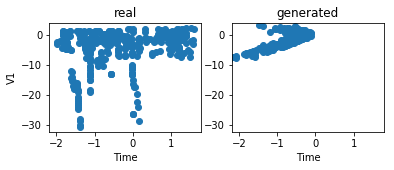

394 394
epoch: 40, Accuracy: 0.9847715736040609
[40/701]	Loss_D: 0.6569	Loss_G: 1.1520	


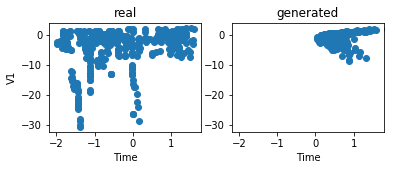

394 394
epoch: 50, Accuracy: 0.9467005076142132
[50/701]	Loss_D: 0.6879	Loss_G: 1.6770	


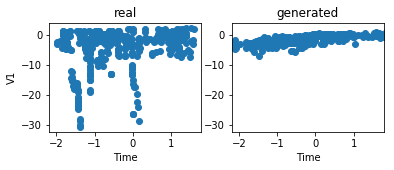

394 394
epoch: 60, Accuracy: 0.9974619289340102
[60/701]	Loss_D: 0.5441	Loss_G: 1.3634	


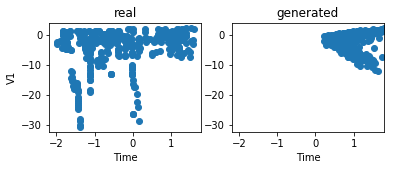

394 394
epoch: 70, Accuracy: 0.9517766497461929
[70/701]	Loss_D: 0.4147	Loss_G: 1.4424	


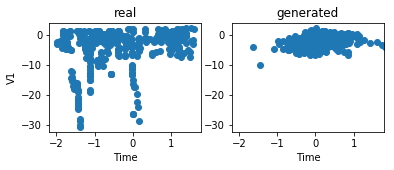

394 394
epoch: 80, Accuracy: 0.9898477157360406
[80/701]	Loss_D: 0.4409	Loss_G: 1.5974	


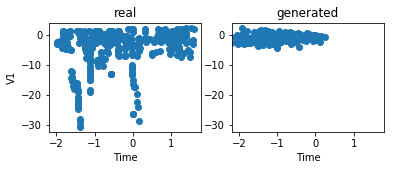

394 394
epoch: 90, Accuracy: 0.9796954314720813
[90/701]	Loss_D: 0.5126	Loss_G: 1.7204	


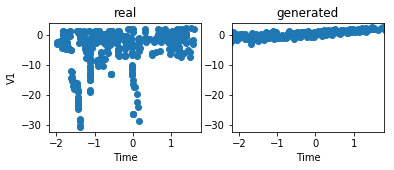

394 394
epoch: 100, Accuracy: 0.949238578680203
[100/701]	Loss_D: 0.3052	Loss_G: 1.8506	


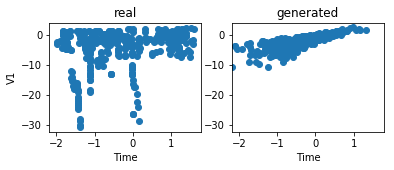

394 394
epoch: 110, Accuracy: 0.9619289340101523
[110/701]	Loss_D: 0.7579	Loss_G: 1.2763	


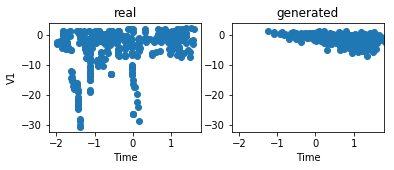

394 394
epoch: 120, Accuracy: 0.9441624365482234
[120/701]	Loss_D: 0.6094	Loss_G: 1.2071	


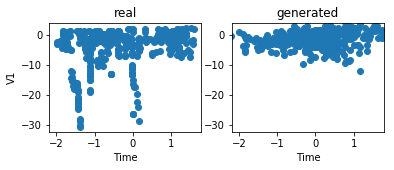

394 394
epoch: 130, Accuracy: 0.9644670050761421
[130/701]	Loss_D: 0.6935	Loss_G: 1.5634	


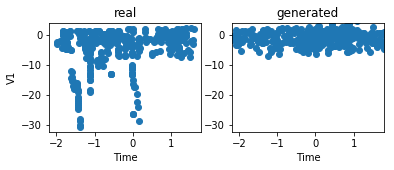

394 394
epoch: 140, Accuracy: 0.9619289340101523
[140/701]	Loss_D: 0.5089	Loss_G: 1.2305	


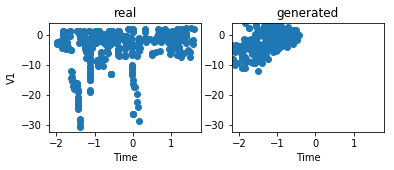

394 394
epoch: 150, Accuracy: 0.9873096446700508
[150/701]	Loss_D: 0.5914	Loss_G: 1.8685	


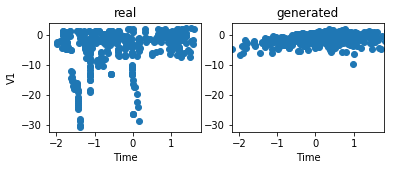

394 394
epoch: 160, Accuracy: 0.9416243654822335
[160/701]	Loss_D: 0.5160	Loss_G: 1.1758	


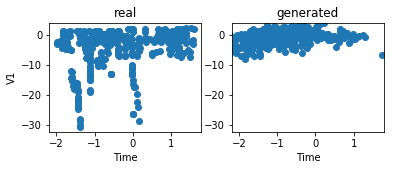

394 394
epoch: 170, Accuracy: 0.9746192893401016
[170/701]	Loss_D: 0.6589	Loss_G: 1.6252	


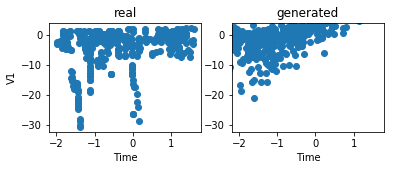

394 394
epoch: 180, Accuracy: 0.9644670050761421
[180/701]	Loss_D: 0.5584	Loss_G: 1.4109	


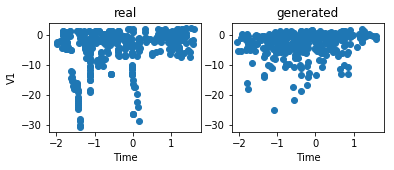

394 394
epoch: 190, Accuracy: 0.934010152284264
[190/701]	Loss_D: 0.5730	Loss_G: 1.4102	


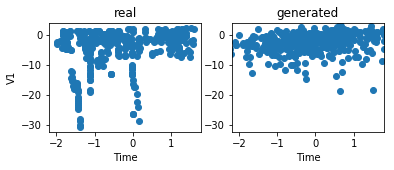

394 394
epoch: 200, Accuracy: 0.9467005076142132
[200/701]	Loss_D: 0.4843	Loss_G: 1.3851	


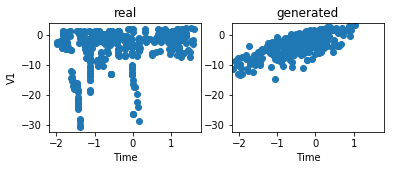

394 394
epoch: 210, Accuracy: 0.9568527918781726
[210/701]	Loss_D: 0.6621	Loss_G: 1.1817	


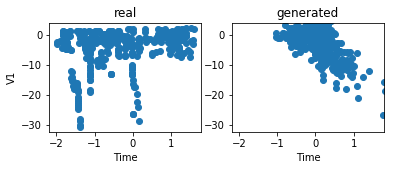

394 394
epoch: 220, Accuracy: 0.9796954314720813
[220/701]	Loss_D: 0.6253	Loss_G: 1.3162	


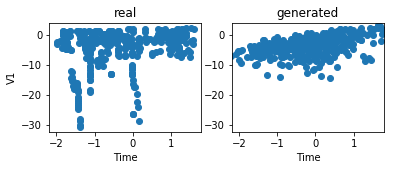

394 394
epoch: 230, Accuracy: 0.9365482233502538
[230/701]	Loss_D: 0.5710	Loss_G: 1.2353	


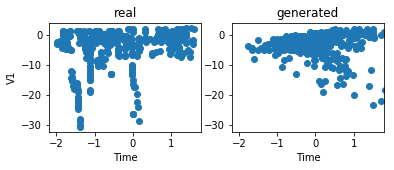

394 394
epoch: 240, Accuracy: 0.9644670050761421
[240/701]	Loss_D: 0.4702	Loss_G: 1.6924	


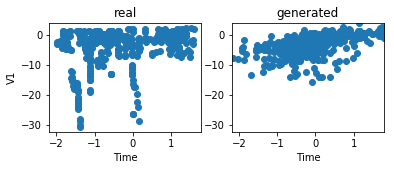

394 394
epoch: 250, Accuracy: 0.9517766497461929
[250/701]	Loss_D: 0.5369	Loss_G: 1.4480	


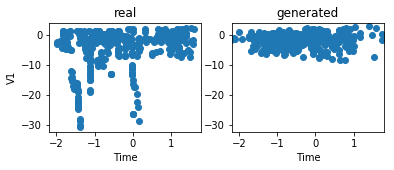

394 394
epoch: 260, Accuracy: 0.9289340101522843
[260/701]	Loss_D: 0.4612	Loss_G: 1.4981	


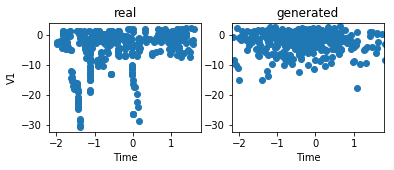

394 394
epoch: 270, Accuracy: 0.9543147208121827
[270/701]	Loss_D: 0.5484	Loss_G: 1.3970	


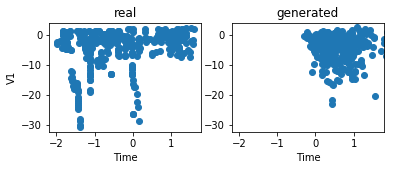

394 394
epoch: 280, Accuracy: 0.9416243654822335
[280/701]	Loss_D: 0.5219	Loss_G: 1.3389	


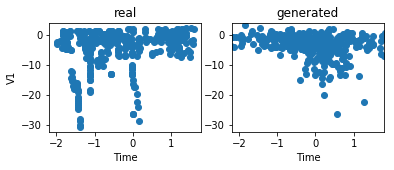

394 394
epoch: 290, Accuracy: 0.9416243654822335
[290/701]	Loss_D: 0.5530	Loss_G: 1.9309	


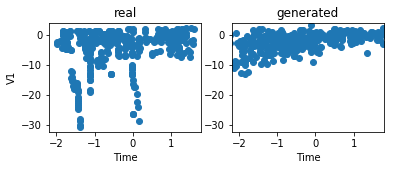

394 394
epoch: 300, Accuracy: 0.9365482233502538
[300/701]	Loss_D: 0.4586	Loss_G: 1.4296	


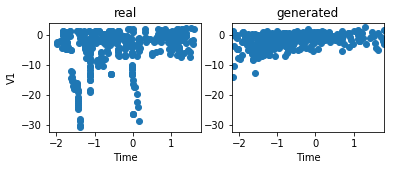

394 394
epoch: 310, Accuracy: 0.9416243654822335
[310/701]	Loss_D: 0.4698	Loss_G: 1.2881	


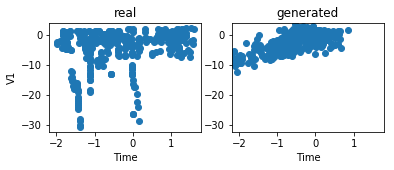

394 394
epoch: 320, Accuracy: 0.9796954314720813
[320/701]	Loss_D: 0.4970	Loss_G: 1.3000	


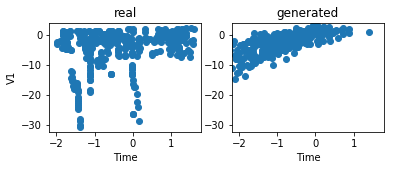

394 394
epoch: 330, Accuracy: 0.9467005076142132
[330/701]	Loss_D: 0.5690	Loss_G: 1.5005	


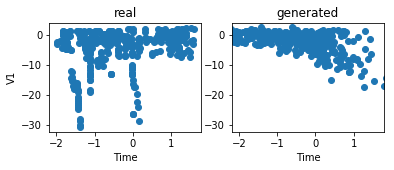

394 394
epoch: 340, Accuracy: 0.9314720812182741
[340/701]	Loss_D: 0.5670	Loss_G: 1.4865	


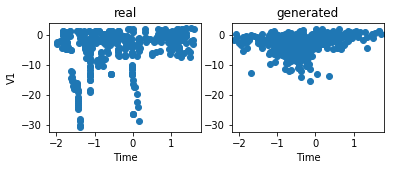

394 394
epoch: 350, Accuracy: 0.9010152284263959
[350/701]	Loss_D: 0.4652	Loss_G: 1.5329	


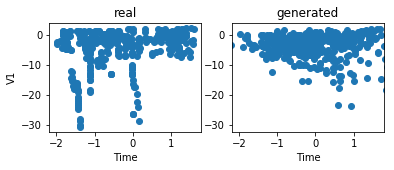

394 394
epoch: 360, Accuracy: 0.9213197969543148
[360/701]	Loss_D: 0.4419	Loss_G: 1.4865	


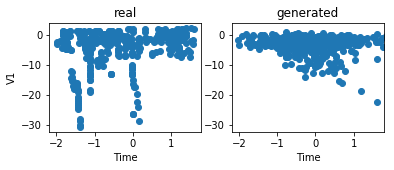

394 394
epoch: 370, Accuracy: 0.9238578680203046
[370/701]	Loss_D: 0.5499	Loss_G: 1.3549	


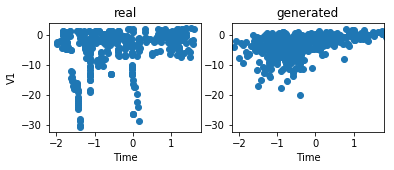

394 394
epoch: 380, Accuracy: 0.9289340101522843
[380/701]	Loss_D: 0.4676	Loss_G: 1.7797	


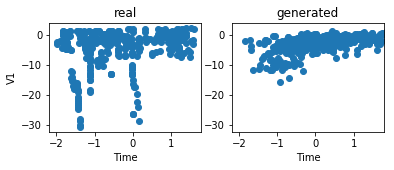

394 394
epoch: 390, Accuracy: 0.9060913705583756
[390/701]	Loss_D: 0.4729	Loss_G: 2.1404	


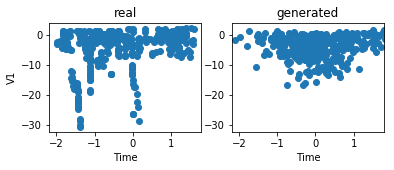

394 394
epoch: 400, Accuracy: 0.8401015228426396
[400/701]	Loss_D: 0.4291	Loss_G: 1.7051	


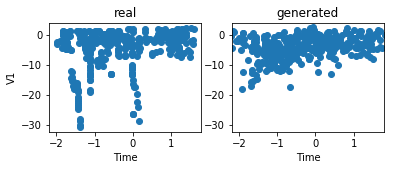

394 394
epoch: 410, Accuracy: 0.9619289340101523
[410/701]	Loss_D: 0.6221	Loss_G: 1.4372	


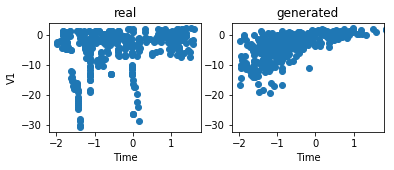

394 394
epoch: 420, Accuracy: 0.9111675126903553
[420/701]	Loss_D: 0.5681	Loss_G: 1.6673	


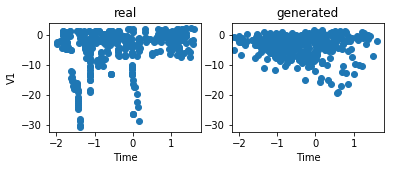

394 394
epoch: 430, Accuracy: 0.8781725888324873
[430/701]	Loss_D: 0.4755	Loss_G: 1.5483	


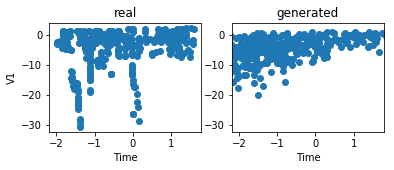

394 394
epoch: 440, Accuracy: 0.934010152284264
[440/701]	Loss_D: 0.4896	Loss_G: 1.5946	


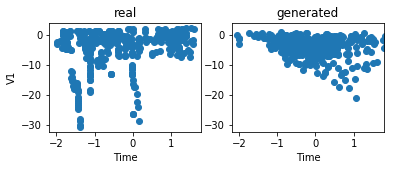

394 394
epoch: 450, Accuracy: 0.9314720812182741
[450/701]	Loss_D: 0.5265	Loss_G: 1.6758	


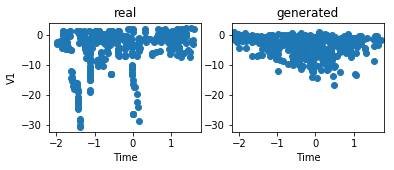

394 394
epoch: 460, Accuracy: 0.8883248730964467
[460/701]	Loss_D: 0.3356	Loss_G: 1.9758	


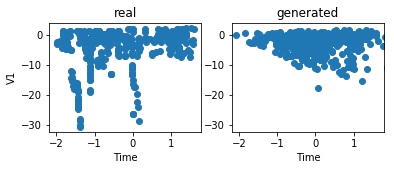

394 394
epoch: 470, Accuracy: 0.9111675126903553
[470/701]	Loss_D: 0.4349	Loss_G: 1.8266	


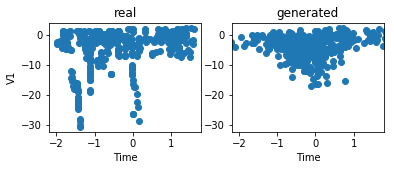

394 394
epoch: 480, Accuracy: 0.9086294416243654
[480/701]	Loss_D: 0.4077	Loss_G: 1.5003	


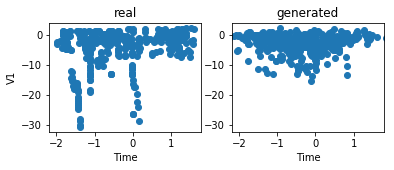

394 394
epoch: 490, Accuracy: 0.8857868020304569
[490/701]	Loss_D: 0.4736	Loss_G: 1.8016	


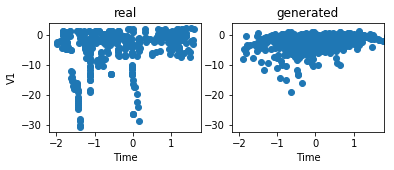

394 394
epoch: 500, Accuracy: 0.8883248730964467
[500/701]	Loss_D: 0.3800	Loss_G: 2.0393	


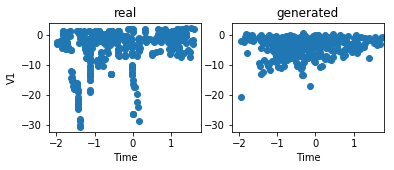

394 394
epoch: 510, Accuracy: 0.9010152284263959
[510/701]	Loss_D: 0.3622	Loss_G: 1.7447	


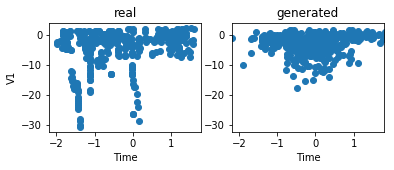

394 394
epoch: 520, Accuracy: 0.8350253807106599
[520/701]	Loss_D: 0.4691	Loss_G: 1.8530	


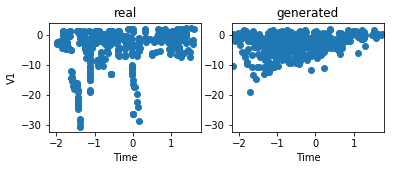

394 394
epoch: 530, Accuracy: 0.8984771573604061
[530/701]	Loss_D: 0.4375	Loss_G: 1.9908	


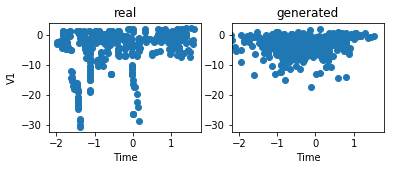

394 394
epoch: 540, Accuracy: 0.9010152284263959
[540/701]	Loss_D: 0.4131	Loss_G: 1.9381	


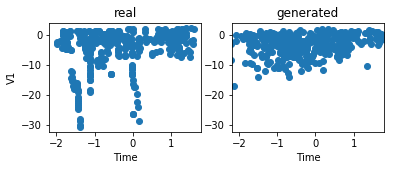

394 394
epoch: 550, Accuracy: 0.8781725888324873
[550/701]	Loss_D: 0.3634	Loss_G: 2.0490	


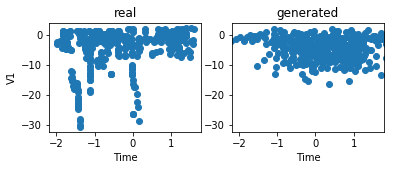

394 394
epoch: 560, Accuracy: 0.8908629441624365
[560/701]	Loss_D: 0.4214	Loss_G: 1.8165	


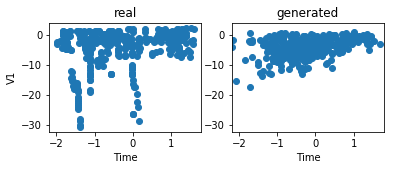

394 394
epoch: 570, Accuracy: 0.8883248730964467
[570/701]	Loss_D: 0.4133	Loss_G: 2.5111	


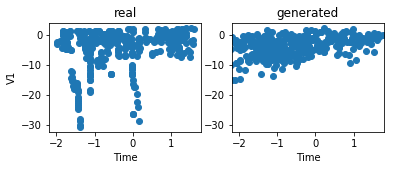

394 394
epoch: 580, Accuracy: 0.8553299492385786
[580/701]	Loss_D: 0.3886	Loss_G: 2.3371	


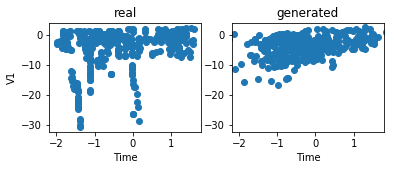

394 394
epoch: 590, Accuracy: 0.934010152284264
[590/701]	Loss_D: 0.4536	Loss_G: 2.0557	


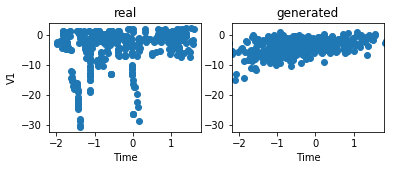

394 394
epoch: 600, Accuracy: 0.8807106598984772
[600/701]	Loss_D: 0.2972	Loss_G: 2.1734	


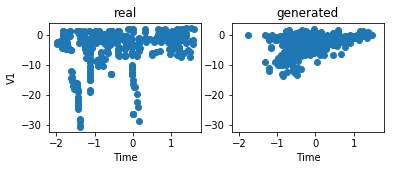

394 394
epoch: 610, Accuracy: 0.8629441624365483
[610/701]	Loss_D: 0.3934	Loss_G: 2.3503	


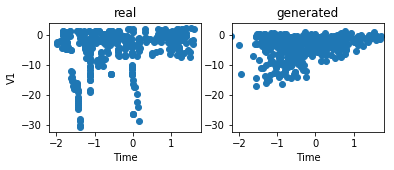

394 394
epoch: 620, Accuracy: 0.9035532994923858
[620/701]	Loss_D: 0.4361	Loss_G: 2.1848	


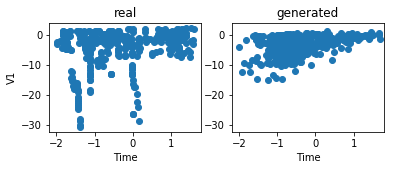

394 394
epoch: 630, Accuracy: 0.8527918781725888
[630/701]	Loss_D: 0.3686	Loss_G: 2.3836	


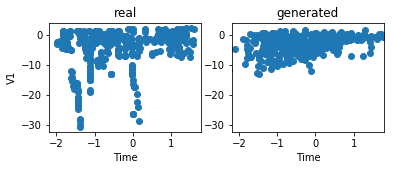

394 394
epoch: 640, Accuracy: 0.8807106598984772
[640/701]	Loss_D: 0.3605	Loss_G: 2.2911	


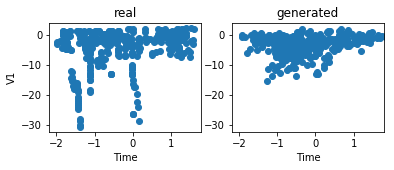

394 394
epoch: 650, Accuracy: 0.8629441624365483
[650/701]	Loss_D: 0.3681	Loss_G: 2.2203	


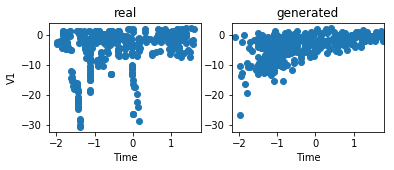

394 394
epoch: 660, Accuracy: 0.8908629441624365
[660/701]	Loss_D: 0.3356	Loss_G: 2.7754	


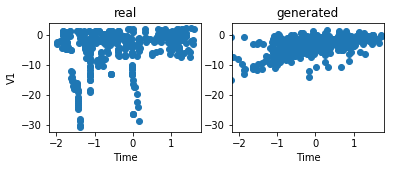

394 394
epoch: 670, Accuracy: 0.8147208121827412
[670/701]	Loss_D: 0.2862	Loss_G: 2.2996	


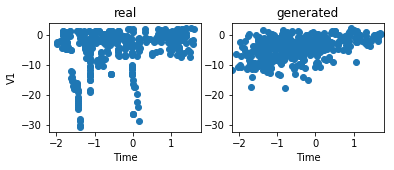

394 394
epoch: 680, Accuracy: 0.8934010152284264
[680/701]	Loss_D: 0.2974	Loss_G: 2.5057	


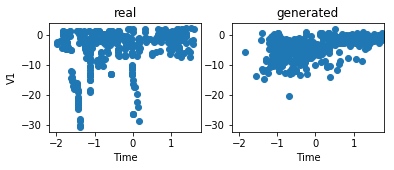

394 394
epoch: 690, Accuracy: 0.8908629441624365
[690/701]	Loss_D: 0.3923	Loss_G: 2.4790	


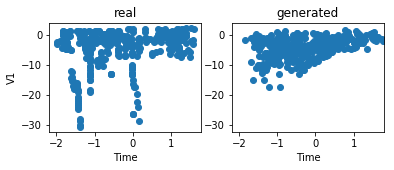

394 394
epoch: 700, Accuracy: 0.8756345177664975
[700/701]	Loss_D: 0.3030	Loss_G: 2.4749	


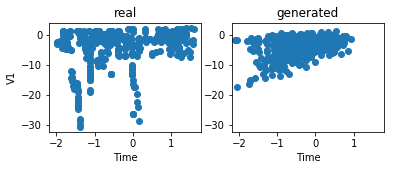

It took  53.64317560195923


In [15]:
xgblosses, G_losses, D_RealLosses, D_FakeLosses, generated_data, real_data_list = gan.train(dataloader, randomNoise_dim = 32, hidden_dim = 64, realData_dim =dataloader.dataset.features.size(1), lr = 0.002, num_epochs=700, feature_cols=feature_cols, device='cpu')

In [16]:
len(generated_data)

394

In [17]:
xgblosses

array([0.83248731, 0.96954315, 0.99492386, 0.98477157, 0.98477157,
       0.94670051, 0.99746193, 0.95177665, 0.98984772, 0.97969543,
       0.94923858, 0.96192893, 0.94416244, 0.96446701, 0.96192893,
       0.98730964, 0.94162437, 0.97461929, 0.96446701, 0.93401015,
       0.94670051, 0.95685279, 0.97969543, 0.93654822, 0.96446701,
       0.95177665, 0.92893401, 0.95431472, 0.94162437, 0.94162437,
       0.93654822, 0.94162437, 0.97969543, 0.94670051, 0.93147208,
       0.90101523, 0.9213198 , 0.92385787, 0.92893401, 0.90609137,
       0.84010152, 0.96192893, 0.91116751, 0.87817259, 0.93401015,
       0.93147208, 0.88832487, 0.91116751, 0.90862944, 0.8857868 ,
       0.88832487, 0.90101523, 0.83502538, 0.89847716, 0.90101523,
       0.87817259, 0.89086294, 0.88832487, 0.85532995, 0.93401015,
       0.88071066, 0.86294416, 0.9035533 , 0.85279188, 0.88071066,
       0.86294416, 0.89086294, 0.81472081, 0.89340102, 0.89086294,
       0.87563452])

In [18]:
number = 0.87817259

In [19]:
for i in range(xgblosses.size):
    if np.round(xgblosses[i],6) == np.round(np.min(xgblosses[2:]),6):
        best_round = i*10
        print(best_round)

670


In [20]:
w=10

0.8147208121827412


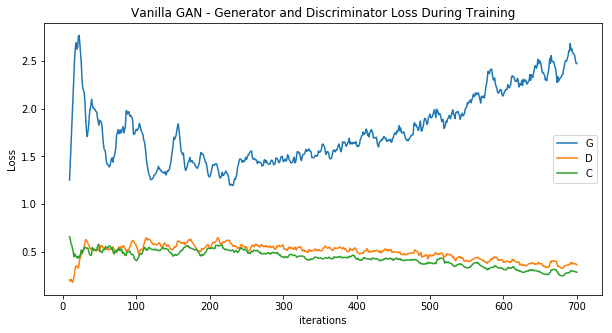

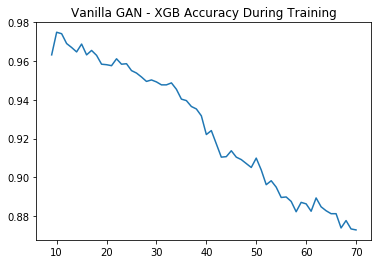

In [21]:
print(min(xgblosses[10:]))
plt.figure(figsize=(10,5))
plt.title(f"Vanilla GAN - Generator and Discriminator Loss During Training")
b = pd.DataFrame(G_losses[:]).rolling(w).mean()
c = pd.DataFrame(D_RealLosses[:]).rolling(w).mean()
d = pd.DataFrame(D_FakeLosses[:]).rolling(w).mean()
# plt.plot(G_losses,label="G")
# plt.plot(D_losses,label="D")
plt.plot(b,label="G")
plt.plot(c,label="D")
plt.plot(d,label="C")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f'reports/figures/gan/GAN.png')
plt.show()


a = pd.DataFrame(xgblosses[:]).rolling(w).mean()
plt.title(f"Vanilla GAN - XGB Accuracy During Training")
plt.plot(a)
plt.savefig(f'reports/figures/gan/xgblosses_GAN.png')
plt.show()

In [22]:
amount=train.shape[0]
device='cpu'

In [23]:
train.shape[0]

227845

In [24]:
randomNoise_dim = 32; hidden_dim = 64; realData_dim =dataloader.dataset.features.size(1)

In [25]:
more_data = gan.generate_data(best_round, randomNoise_dim, hidden_dim, realData_dim, amount, 'cpu')

In [26]:
more_data = more_data.detach().numpy()

In [27]:
b = np.ones((more_data.shape[0],more_data.shape[1]+1))
b[:,:-1] = more_data

In [28]:
b.shape

(227845, 31)

In [29]:
df_generatedData = pd.DataFrame(b, columns = feature_cols + label_col)
df_generatedData.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.170618,-6.150320,0.209296,-6.733312,6.069298,-0.347274,-2.148469,-6.072817,2.400481,-4.973002,...,1.281423,1.190765,-0.209502,-0.125325,-0.659226,0.509851,1.705384,-0.053194,-0.109737,1.0
1,-0.033093,-6.299328,2.663376,-7.398191,6.541225,-6.058370,-1.900338,-5.980523,3.347392,-3.373898,...,2.305836,1.192571,-1.035557,0.415331,-1.818708,-0.135328,-0.478352,0.965111,0.470753,1.0
2,-1.638597,-1.685765,2.658446,-5.860065,4.643134,-4.158216,-2.347775,-7.866804,1.981668,-4.597720,...,1.669395,0.439634,-0.830400,-0.316320,0.716817,0.024273,1.892060,0.964873,-0.184966,1.0
3,-0.188163,0.036242,2.214471,-3.622247,3.494362,-0.391805,-1.563000,-2.228907,0.866745,-2.957085,...,0.277609,-0.371228,-0.407706,-0.486715,0.902722,-0.426751,0.632920,0.373576,-0.071470,1.0
4,-0.302600,-2.313852,1.566186,-5.725707,4.126711,-0.710577,-3.062325,-5.805604,1.395473,-3.443804,...,1.169198,0.428906,-0.658187,-0.490181,0.487615,-0.016078,1.535786,0.319541,-0.478029,1.0


In [30]:
train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [31]:
train = train.append(df_generatedData)
train = train.sample(frac=1)

In [32]:
train.shape

(455690, 31)

In [33]:
train.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [34]:
train_y = train.Class

In [35]:
train_y

216163    1.0
13242     1.0
102762    1.0
48172     0.0
216058    1.0
77145     1.0
134567    0.0
10187     0.0
17817     1.0
72313     0.0
18732     0.0
136774    1.0
172132    0.0
221678    0.0
259236    0.0
28100     1.0
161868    0.0
108554    0.0
116575    0.0
62395     0.0
27365     1.0
188104    0.0
127790    1.0
12926     1.0
21465     1.0
57254     0.0
218973    0.0
203811    0.0
51689     0.0
195918    0.0
         ... 
2062      1.0
97169     0.0
162597    0.0
125537    1.0
238364    0.0
129883    1.0
143717    1.0
196023    1.0
106098    0.0
117468    0.0
273672    0.0
241783    0.0
215998    1.0
73336     1.0
106214    1.0
210194    1.0
149931    1.0
177241    1.0
24483     0.0
82700     1.0
20703     1.0
130037    1.0
84558     0.0
101964    1.0
102589    0.0
63422     1.0
40840     1.0
181280    0.0
258870    0.0
28438     0.0
Name: Class, Length: 455690, dtype: float64

In [36]:
train_y.isnull().sum()

0

In [37]:
train_X = train

In [38]:
train_X.drop('Class', axis=1, inplace=True)

# XGBoost

In [39]:
train_y.head()

216163    1.0
13242     1.0
102762    1.0
48172     0.0
216058    1.0
Name: Class, dtype: float64

In [40]:
train_X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
216163,1.722727,-0.605456,2.026364,-5.258384,2.399988,-0.615731,-2.171623,-2.483687,0.845576,-2.287220,...,0.839652,0.705090,0.666951,-0.102096,-0.221257,0.322918,0.012243,0.752315,0.378455,-0.210748
13242,2.012980,0.532029,3.287316,-5.761413,4.733056,-0.132112,-2.729670,-1.534678,0.545851,-3.546419,...,0.722484,0.358520,-0.311976,-0.516316,-0.130986,0.347656,0.120589,0.636300,0.352399,-0.227523
102762,-1.383352,-1.386292,2.439468,-4.876912,4.552982,-3.498142,-1.344235,-6.481234,1.654472,-4.163267,...,0.790523,1.376367,0.438097,-0.616580,-0.274298,0.754003,-0.075845,1.572798,0.878731,-0.056134
48172,-1.079644,-3.137990,0.657136,0.155186,-2.557415,-2.669855,0.433551,-1.718465,2.093902,-2.461860,...,-0.342059,0.088903,0.410843,-0.179507,-0.310111,0.438842,-0.110332,0.239776,-0.059344,0.068725
216058,-0.918982,-3.775483,2.821898,-3.954607,4.843424,-3.603151,-1.039013,-5.680645,2.351430,-4.278778,...,0.194128,1.534976,0.659730,-0.503849,0.119805,-0.070102,-0.193774,0.590358,0.337773,0.050499


In [41]:
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [42]:
train_y.shape

(455690,)

In [43]:
start_time = time.time()
dtrain = xgb.DMatrix(train_X, train_y, feature_names=feature_cols)
dtest = xgb.DMatrix(test_X, feature_names=feature_cols)

results_dict = {}

param = {
        'max_depth':5, 
        'eta':0.3, 
        'verbosity': 1, 
        'objective':'binary:logistic', 
        'eval_metric': 'auc', 
        'seed': 42
        }

model = xgb.train(param, dtrain, num_boost_round=100)
# make prediction
preds = np.round(model.predict(dtest))
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

/home/chinne/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/chinne/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Time elapsed to train:  43.291383028030396


In [44]:
print('---' * 45)
print('XGBoost ROC/AUC: {:.6f}'.format(roc_auc_score(test_y, preds)))
print('Recall Score: {:.6f}'.format(recall_score(test_y, preds)))
print('Precision Score: {:.6f}'.format(precision_score(test_y, preds)))
print('F1 Score: {:.6f}'.format(f1_score(test_y, preds)))
print('Accuracy Score: {:.6f}'.format(accuracy_score(test_y, preds)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
XGBoost ROC/AUC: 0.923329
Recall Score: 0.846939
Precision Score: 0.838384
F1 Score: 0.842640
Accuracy Score: 0.999456
---------------------------------------------------------------------------------------------------------------------------------------
